# Infering properties of the MRT network from ridership data

## Imports

Requires seaborn, pandas, networkx, pygraphviz python libraries.
Requires graphviz library.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

In [3]:
import numpy as np
import pandas as pd

In [4]:
import networkx as nx
import pygraphviz as pgv

In [5]:
print(pd.__version__)
print(nx.__version__)
print(pgv.__version__)

0.19.2
1.11
1.3.1


## Magic numbers

All quantities below are in minutes.

In [6]:
TRIP_MIN_WEIGHT = 1.5  # Minimum travel time between stations
DIRECT_NEIGHBOUR_MAX_WEIGHT = 15  # Threshold for direct neighbours
GRAPH_CYCLE_WEIGHT_MULTIPLIER_THRESHOLD = 2.8
TRAVEL_TIME_TOLERANGE_RANGE = 2

## Utility functions

Pandas utilities

In [7]:
def replace_with_id(df_in, df_in_col, ds_in, ds_in_name=None, append_str='_id'):
    if ds_in_name:
        ds_in.name = ds_in_name
    elif not ds_in.name:
        ds_in.name = 'name'

    df_from_ds = ds_in.to_frame()
    df_from_ds.reset_index(inplace=True)
    df_from_ds['index'] = df_from_ds['index'].apply(lambda x: pd.to_numeric(x, downcast='unsigned'))

    df = pd.merge(df_in,
                  df_from_ds,
                  how='left', left_on=df_in_col, right_on=ds_in.name, sort=False)
    df.rename(columns={'index': df_in_col + append_str}, inplace=True)
    df.drop([ds_in.name, df_in_col], axis=1, inplace=True)

    return df

In [8]:
def replace_with_obj(df_in, df_in_col, ds_in, append_str='_obj'):
    if ds_in.name:
        ds_in_col = ds_in.name
    else:
        ds_in_col = 'name'

    df = pd.merge(df_in,
                  ds_in.to_frame(),
                  how='left', left_on=df_in_col, right_index=True, sort=False)
    df.rename(columns={ds_in_col: str(df_in_col) + append_str}, inplace=True)
    df.drop(df_in_col, axis=1, inplace=True)

    return df

In [9]:
def get_idx(ds, x):
    """Retrieves index of item from a series."""
    i = ds[ds == x].index
    if len(i) > 0:
        return i.item()
    else:
        return None

Graph utilities

In [10]:
def nearest_neighbour(g, node, weight_label='weight'):
    return min(((x, d[weight_label]) for x, d in g[node].items()), key=(lambda x: x[1]))

Others

In [11]:
def convert_time_to_int(t, delimeter=':'):
    """Converts time in the form hh:mm:ss to an integer representing number of
    seconds since midnight."""

    units = [3600, 60, 1]
    return sum(u * x for u, x in zip(units, (int(a) for a in t.split(delimeter))))

## Basic data processing

Read in user data

In [12]:
trip_data = pd.read_csv(r'mrt_trips_sampled.csv').set_index('index')
print(trip_data.shape)
trip_data.head()

(381249, 4)


,destination,destination_tm,origin,origin_tm
index,,,,
0,Bugis DTL,10:04:47,Stevens,09:52:23
1,Kent Ridge,10:11:34,Sengkang,09:27:41
2,Tai Seng,09:35:59,Compassvale,09:03:44
3,Labrador Park,09:45:50,Bishan NSEW,09:14:45
4,Joo Koon,09:27:32,Boon Lay,09:20:36


Create a table of MRT station names.

In [13]:
mrt_stations = pd.Series(pd.concat([trip_data['destination'], trip_data['origin']]).unique())
mrt_stations.name = 'station_name'
mrt_stations.size

154

Replace MRT station name string with an index.

In [14]:
trip_data = replace_with_id(replace_with_id(trip_data, 'origin', mrt_stations),
                      'destination', mrt_stations)
trip_data['origin_tm'] = trip_data['origin_tm'].apply(convert_time_to_int)
trip_data['destination_tm'] = trip_data['destination_tm'].apply(convert_time_to_int)
trip_data.head()

,destination_tm,origin_tm,origin_id,destination_id
0,36287,35543,138,0
1,36694,34061,31,1
2,34559,32624,146,2
3,35150,33285,121,3
4,34052,33636,17,4


Check that underlying datatypes are what we expect

In [15]:
trip_data.dtypes

destination_tm    int64
origin_tm         int64
origin_id         int64
destination_id    int64
dtype: object

## Data clean up

Find travel time in minutes.

In [16]:
trip_data['travel_time_mins'] = (trip_data['destination_tm'] - trip_data['origin_tm']) / 60
#trip_data.drop(['origin_tm', 'destination_tm'], axis=1, inplace=True)
trip_data.head()

,destination_tm,origin_tm,origin_id,destination_id,travel_time_mins
0,36287,35543,138,0,12.400000
1,36694,34061,31,1,43.883333
2,34559,32624,146,2,32.250000
3,35150,33285,121,3,31.083333
4,34052,33636,17,4,6.933333


In [17]:
def find_close_station_names(mrt_stations):
    import re

    s1 = ''
    s1_stripped = ''
    network_names = ['CCL', 'DTL', 'BPLRT', 'NEL', 'NSEW']
    ans = []
    for s2 in sorted(mrt_stations):  # Lexical sort
        s2_stripped = re.sub('|'.join(network_names), '', s2).strip()
        if s1_stripped == s2_stripped:
            ans.append((get_idx(mrt_stations, s1), get_idx(mrt_stations, s2), s1_stripped))
        s1 = s2
        s1_stripped = s2_stripped
    return ans

find_close_station_names(mrt_stations)

[(99, 53, 'Bayfront'),
 (70, 121, 'Bishan'),
 (92, 130, 'Botanic Gardens'),
 (0, 16, 'Bugis'),
 (94, 102, 'Bukit Panjang'),
 (28, 90, 'Buona Vista'),
 (80, 20, 'Chinatown'),
 (5, 119, 'Choa Chu Kang'),
 (65, 25, 'Dhoby Ghaut'),
 (32, 24, 'HarbourFront'),
 (81, 86, 'Little India'),
 (120, 149, 'Marina Bay'),
 (10, 100, 'Newton'),
 (55, 40, 'Outram Park'),
 (62, 75, 'Paya Lebar'),
 (48, 104, 'Serangoon')]

Identify similiar station names with each other; i.e. assume they are the same station.

In [18]:
for s1, s2, short_name in find_close_station_names(mrt_stations):
    if s1 > s2:
        s1, s2 = s2, s1
    mrt_stations.drop(s2, inplace=True)
    mrt_stations.loc[s1] = short_name

    trip_data.loc[trip_data['origin_id'] == s2, 'origin_id'] = s1
    trip_data.loc[trip_data['destination_id'] == s2, 'destination_id'] = s1

There are 2031 trips that start and end at the same station! (With another 189 trips between interchange stations.)

In [19]:
trip_data[trip_data['origin_id'] == trip_data['destination_id']].shape

(2220, 5)

Remove trips which start and end at the same station.

In [20]:
trip_data = trip_data[trip_data['origin_id'] != trip_data['destination_id']]

Distribution of trip times < 5 min.

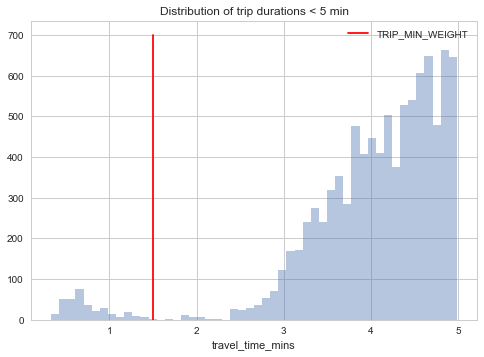

In [21]:
fig, ax = plt.subplots()
sns.distplot(trip_data.loc[trip_data.loc[:, 'travel_time_mins'] < 5, 'travel_time_mins'], kde=False, ax=ax)
ax.set_title('Distribution of trip durations < 5 min')
ax.plot((TRIP_MIN_WEIGHT, TRIP_MIN_WEIGHT), (0, 700), 'r-', label='TRIP_MIN_WEIGHT')
ax.legend();

Delete travel times less than TRIP_MIN_WEIGHT.

In [22]:
trip_data.drop(trip_data.loc[(trip_data.loc[:, 'travel_time_mins'] < TRIP_MIN_WEIGHT)].index, axis=0, inplace=True)

## Data preview

### Are there missing edges?

In [23]:
origin_dest_pairs = set(zip(trip_data['origin_id'], trip_data['destination_id']))
'Number of origin-destination pairs = %d' % len(origin_dest_pairs)

'Number of origin-destination pairs = 9336'

In [24]:
no_origin_dest = set()
for i in mrt_stations.index:
    for j in mrt_stations.index:
        if i != j and (i, j) not in origin_dest_pairs:
            no_origin_dest.add((i, j))

'Number of origin-destination pairs not present = %d' % len(no_origin_dest)

'Number of origin-destination pairs not present = 9570'

Sanity check

In [25]:
len(origin_dest_pairs) + len(no_origin_dest) == mrt_stations.size**2 - mrt_stations.size

True

In [26]:
origin_dest_pairs_unordered = set(tuple(sorted(e)) for e in origin_dest_pairs)
'Number of unordered origin-destination pairs = %d' % len(origin_dest_pairs_unordered)

'Number of unordered origin-destination pairs = 5972'

In [27]:
no_origin_dest_unordered = set()
for i in mrt_stations.index:
    for j in filter(lambda a: a > i, mrt_stations.index):
        if (i, j) not in origin_dest_pairs_unordered:
            no_origin_dest_unordered.add((i, j))

'Number of unordered origin-destination pairs not present = %d' % len(no_origin_dest_unordered)

'Number of unordered origin-destination pairs not present = 3481'

Sanity check

In [28]:
len(origin_dest_pairs_unordered) + len(no_origin_dest_unordered) == 0.5 * mrt_stations.size * (mrt_stations.size - 1)

True

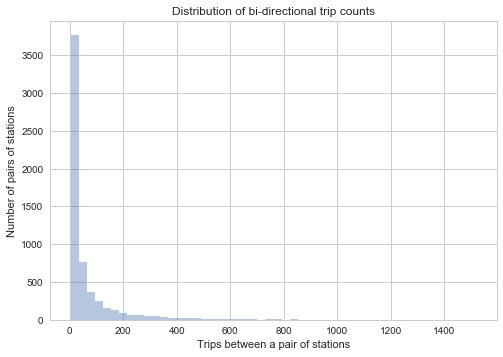

In [29]:
origin_dest_pairs_unordered_count = {}
for o, d in zip(trip_data['origin_id'], trip_data['destination_id']):
    if o > d:
        o, d = d, o

    if (o, d) in origin_dest_pairs_unordered_count:
        origin_dest_pairs_unordered_count[(o, d)] += 1
    else:
        origin_dest_pairs_unordered_count[(o, d)] = 1

fig, ax = plt.subplots()
sns.distplot(list(origin_dest_pairs_unordered_count.values()), kde=False, ax=ax)
ax.set_xlabel('Trips between a pair of stations')
ax.set_ylabel('Number of pairs of stations')
ax.set_title('Distribution of bi-directional trip counts');

In [30]:
def get_trips_between_station_id(data, origin_id, dest_id, origin_col='origin_id', dest_col='destination_id'):
    forward_trips = (data[origin_col] == origin_id) & (data[dest_col] == dest_id)
    reverse_trips = (data[origin_col] == dest_id) & (data[dest_col] == origin_id)
    return data.loc[forward_trips | reverse_trips]

(18, 64) 1521


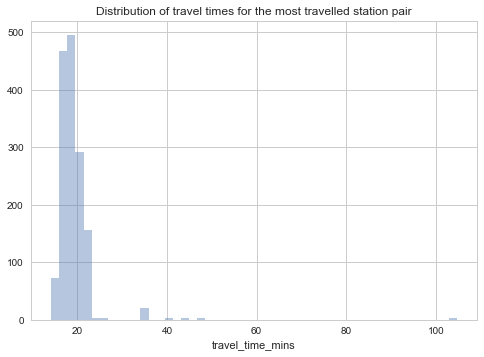

In [31]:
max_pair_id, count = max(origin_dest_pairs_unordered_count.items(), key=(lambda x: x[1]))
print(max_pair_id, count)

fig, ax = plt.subplots()
sns.distplot(get_trips_between_station_id(trip_data, *max_pair_id)['travel_time_mins'], kde=False, ax=ax)
ax.set_title('Distribution of travel times for the most travelled station pair');

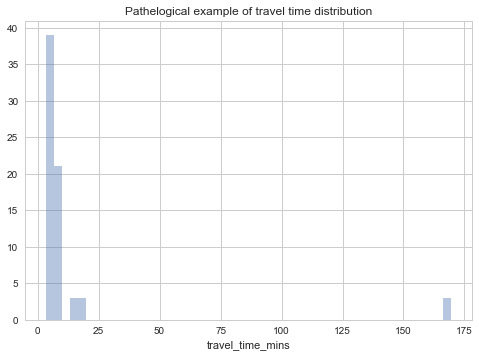

In [32]:
fig, ax = plt.subplots()
sns.distplot(get_trips_between_station_id(trip_data, 28, 97)['travel_time_mins'], kde=False, ax=ax)
ax.set_title('Pathelogical example of travel time distribution');

There are duplicate rows; it is not clear that they are erronous. Did not filter out repeated entries.

In [33]:
origin_dest_pairs_only_duplicates = set()

for (o_id, d_id), df in trip_data.groupby(['origin_id', 'destination_id'], sort=False):
    if df.shape[0] <= 1:
        continue

    n_unique_values = sum(1 for x in df.duplicated(['destination_tm', 'origin_tm'], keep='first') if not x)
    # print(o_id, d_id, n_unique_values)
    if n_unique_values == 1:
        origin_dest_pairs_only_duplicates.add((o_id, d_id))

count = 0
for o_id, d_id in origin_dest_pairs_only_duplicates:
    if (d_id, o_id) in origin_dest_pairs_only_duplicates or (d_id, o_id) in no_origin_dest:
        count += 1
        #print('"{}" "{}"'.format(mrt_stations[o_id], mrt_stations[d_id]))
print('Number of station pairs with only 1 duplicated trip between them = {}'.format(count))

Number of station pairs with only 1 duplicated trip between them = 1373


In [34]:
sum(1 for x in trip_data.duplicated(keep='first') if x)

252731

### Properties of the trip network

In [35]:
trip_median_times_uo = {}

for pair_id in origin_dest_pairs_unordered:
    t = get_trips_between_station_id(trip_data, *pair_id).loc[:, 'travel_time_mins'].median()
    trip_median_times_uo[pair_id] = t

In [36]:
trip_network_uo = nx.Graph()
trip_network_uo.add_weighted_edges_from((o, d, t) for (o, d), t in trip_median_times_uo.items())
nx.freeze(trip_network_uo)
trip_network_uo.number_of_edges()

5972

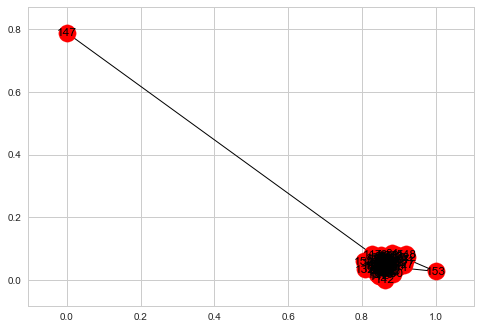

In [37]:
nx.draw_networkx(trip_network_uo, nx.spring_layout(trip_network_uo))

Distribution of station-to-station times

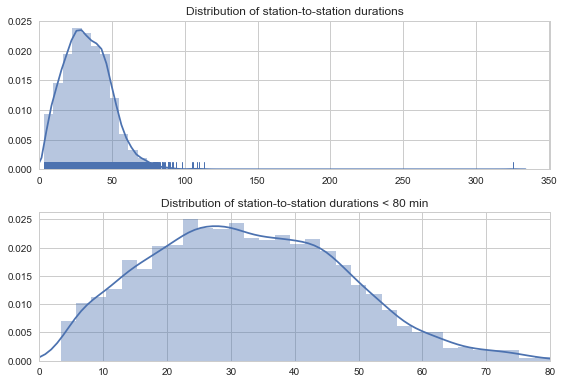

In [38]:
fig, ax = plt.subplots(2)
sns.distplot(list(t for _, _, t in trip_network_uo.edges_iter(data='weight')), ax=ax[0], rug=True)
ax[0].set_title('Distribution of station-to-station durations')
ax[0].set_xlim(xmin=0)
zoom = 80
sns.distplot(list(t for _, _, t in trip_network_uo.edges_iter(data='weight') if t < zoom), ax=ax[1], rug=False)
ax[1].set_title('Distribution of station-to-station durations < %d min' % zoom)
ax[1].set_xlim(0, zoom)
fig.tight_layout();

Fraction of routes < 10 min

In [39]:
sum(1 for _, _, t in trip_network_uo.edges_iter(data='weight') if t < 10) / trip_network_uo.number_of_edges()

0.06262558606831882

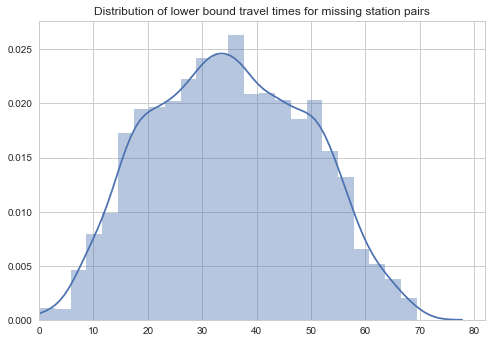

In [40]:
no_origin_dest_unordered_travel_time_lower_bound = {}

for o_id, d_id in no_origin_dest_unordered:
    trip_label = (o_id, d_id)
    o_nearest, o_nearest_t = nearest_neighbour(trip_network_uo, o_id)
    d_nearest, d_nearest_t = nearest_neighbour(trip_network_uo, d_id)

    # Assume that the origin has the closest neighbour
    if o_nearest_t > d_nearest_t:
        o_nearest, d_nearest = d_nearest, o_nearest
        o_nearest_t, d_nearest_t = d_nearest_t, o_nearest_t
        o_id, d_id = d_id, o_id

    min_bound = nx.astar_path_length(trip_network_uo, o_nearest, d_id) - o_nearest_t
    no_origin_dest_unordered_travel_time_lower_bound[trip_label] = min_bound

fig, ax = plt.subplots()
sns.distplot(list(no_origin_dest_unordered_travel_time_lower_bound.values()), ax=ax)
ax.set_xlim(xmin=0)
ax.set_title('Distribution of lower bound travel times for missing station pairs');

## Q1: Inferring underlying train network

In [41]:
train_network = nx.Graph(trip_network_uo)
i = 0
for o, d, t in sorted(trip_network_uo.edges_iter(data='weight'), key=lambda x: x[2], reverse=True):
    i += 1
    if i % 1000 == 0:
        print('Iteration %d' % i)

    data_tmp = train_network.get_edge_data(o, d)
    train_network.remove_edge(o, d)
    path_length = float('inf')
    # Note: this is faster than catching the nx.NetworkXNoPath exception
    if nx.has_path(train_network, o, d):
        path_length = nx.astar_path_length(train_network, o, d)
        if abs(path_length / t - GRAPH_CYCLE_WEIGHT_MULTIPLIER_THRESHOLD) < 0.5:
            print('%s (%d), %s (%d), time: %f, alternate path length: %f, fraction: %f' % \
                  (mrt_stations[o], o, mrt_stations[d], d, t, path_length, path_length / t))

    # reject
    if path_length > (GRAPH_CYCLE_WEIGHT_MULTIPLIER_THRESHOLD * t):
        train_network.add_edge(o, d, data_tmp)

Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
South View (84), Lavender (34), time: 9.383333, alternate path length: 28.483333, fraction: 3.035524
Cheng Lim (132), Thanggam (142), time: 8.733333, alternate path length: 28.341667, fraction: 3.245229
Little India (81), Newton (10), time: 6.800000, alternate path length: 20.158333, fraction: 2.964461
Cove (145), Punggol (114), time: 6.766667, alternate path length: 22.000000, fraction: 3.251232
Ranggung (143), Bakau (125), time: 6.383333, alternate path length: 17.391667, fraction: 2.724543
South View (84), Teck Whye (56), time: 5.533333, alternate path length: 15.200000, fraction: 2.746988


In [42]:
train_network.size()

158

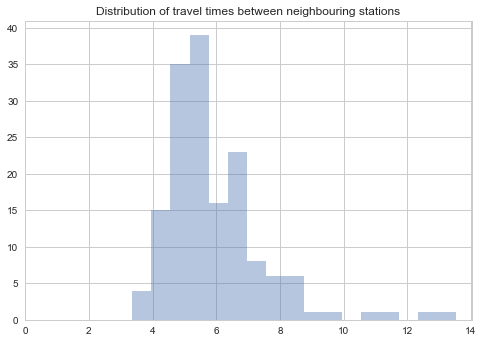

In [43]:
fig, ax = plt.subplots()
sns.distplot(list(t for _, _, t in train_network.edges_iter(data='weight')), kde=False, ax=ax)
ax.set_xlim(xmin=0)
ax.set_title('Distribution of travel times between neighbouring stations');

Check long trips

In [44]:
for o, d, t in train_network.edges_iter(data='weight'):
    if t > 10:
        print('%s (%d), %s (%d), time: %f' % (mrt_stations[o], o, mrt_stations[d], d, t))

Fajar (15), Ten Mile Junction (153), time: 13.516667
Cove (145), Nibong (150), time: 11.150000
Tanah Merah (43), Expo NSEW (66), time: 10.550000
Punggol (114), Sumang (152), time: 12.741667


In [45]:
s1 = get_idx(mrt_stations, 'Lavender')
s2 = get_idx(mrt_stations, 'South View')
print(s1, s2)
if train_network.has_edge(s1, s2):
    train_network.remove_edge(s1, s2)

s1 = get_idx(mrt_stations, 'Raffles Place')
s2 = get_idx(mrt_stations, 'Petir')
print(s1, s2)
if train_network.has_edge(s1, s2):
    train_network.remove_edge(s1, s2)

34 84
37 148


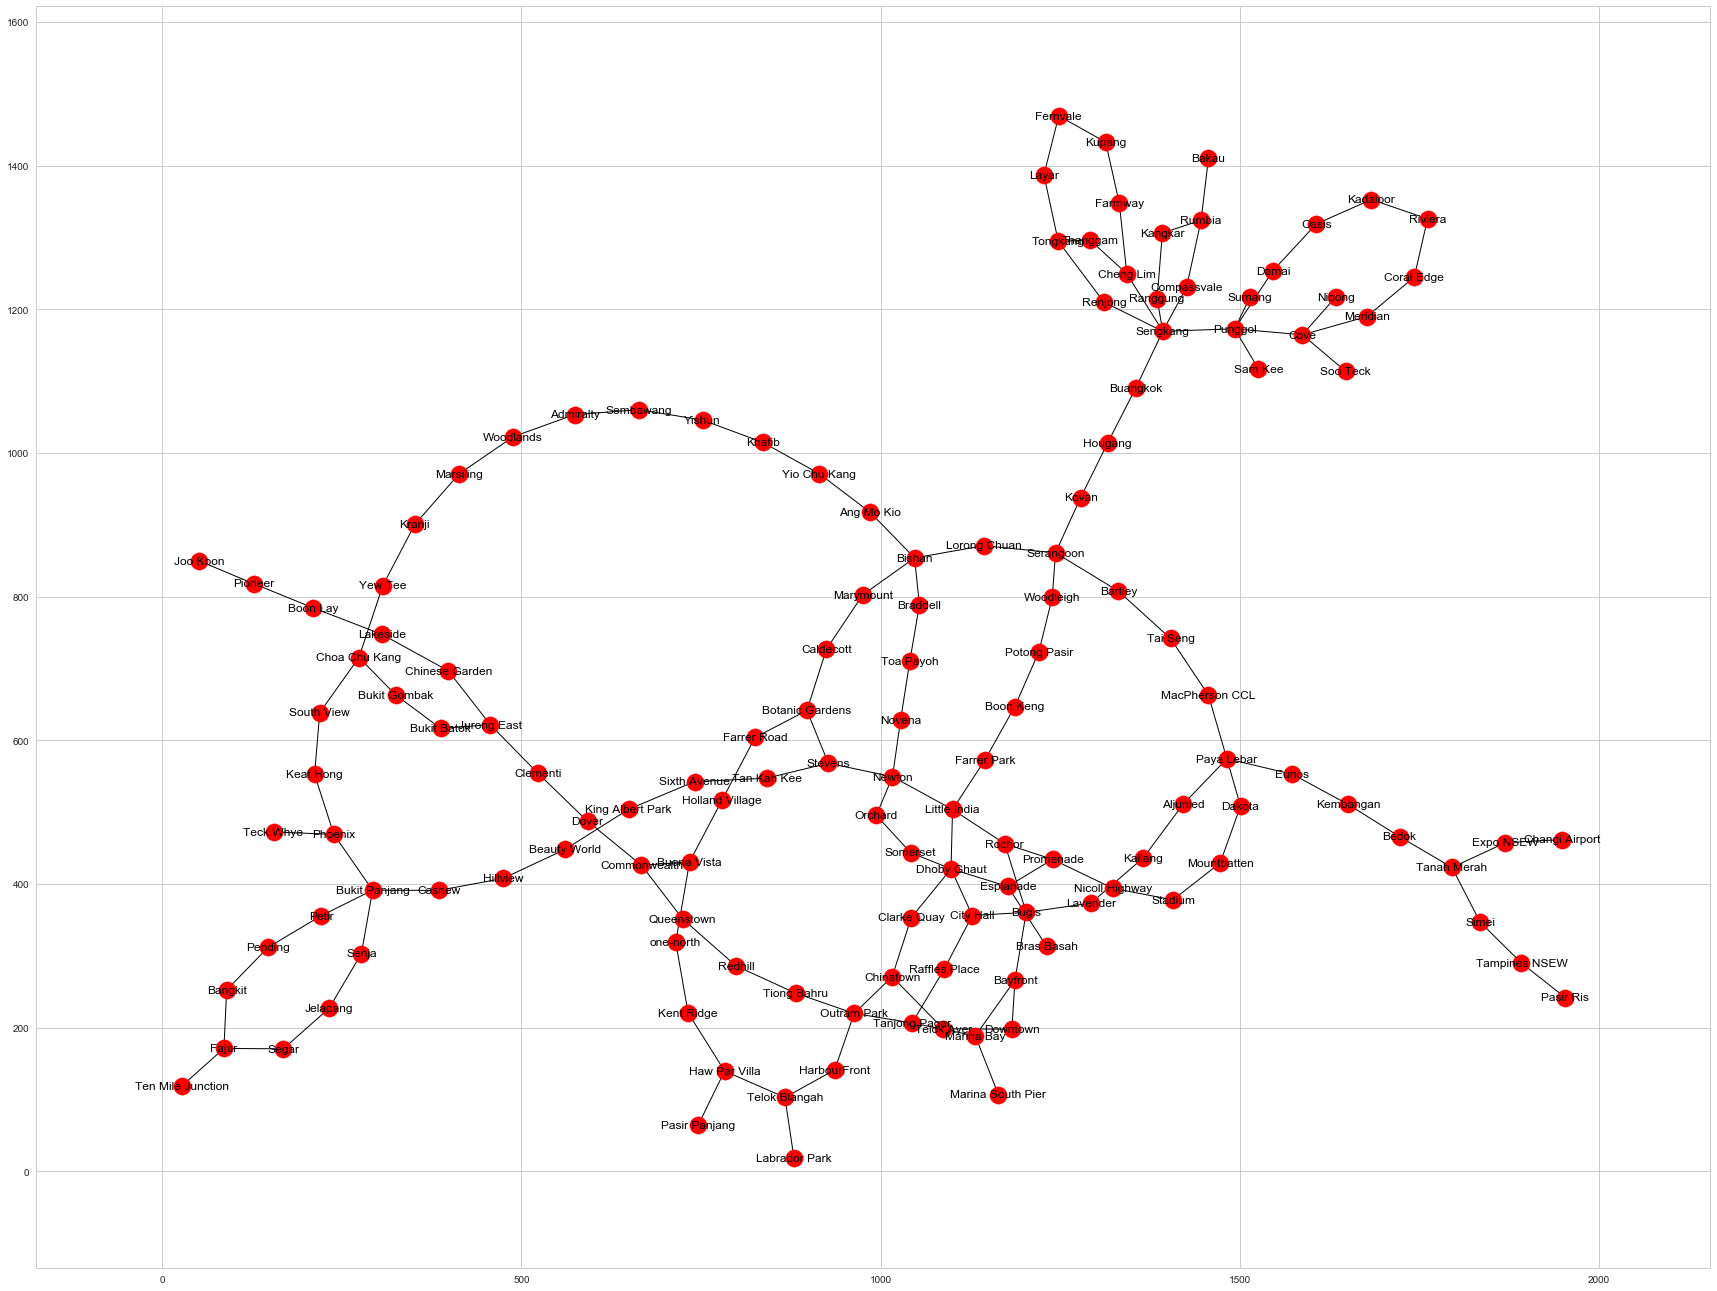

In [46]:
fig, ax = plt.subplots(figsize=(30,30))
ax.set_aspect('equal')
nx.draw_networkx(train_network, nx.nx_pydot.graphviz_layout(train_network), ax=ax, labels=mrt_stations)
fig.savefig(r'train_network.svg')

In [47]:
s1 = get_idx(mrt_stations, 'Tan Kah Kee')
s2 = get_idx(mrt_stations, 'Botanic Gardens')
s3 = get_idx(mrt_stations, 'Stevens')
print(s1, s2, s3)

m12 = get_trips_between_station_id(trip_data, s1, s2).loc[:, 'travel_time_mins'].median()
m23 = get_trips_between_station_id(trip_data, s2, s3).loc[:, 'travel_time_mins'].median()
m13 = get_trips_between_station_id(trip_data, s1, s3).loc[:, 'travel_time_mins'].median()
print(m12, m23, m13)

141 92 138
9.716666666666667 7.391666666666667 5.683333333333334


In [48]:
s1 = get_idx(mrt_stations, 'Rochor')
s2 = get_idx(mrt_stations, 'Bugis')
s3 = get_idx(mrt_stations, 'Promenade')
print(s1, s2, s3)

m12 = get_trips_between_station_id(trip_data, s1, s2).loc[:, 'travel_time_mins'].median()
m23 = get_trips_between_station_id(trip_data, s2, s3).loc[:, 'travel_time_mins'].median()
m13 = get_trips_between_station_id(trip_data, s1, s3).loc[:, 'travel_time_mins'].median()
print(m12, m23, m13)

82 0 26
6.95 7.183333333333334 6.866666666666666


In [49]:
s1 = get_idx(mrt_stations, 'Lavender')
s2 = get_idx(mrt_stations, 'South View')
print(s1, s2)

get_trips_between_station_id(trip_data, s1, s2)

34 84


,destination_tm,origin_tm,origin_id,destination_id,travel_time_mins
21257,33734,33171,34,84,9.383333
147815,33734,33171,34,84,9.383333
275432,33734,33171,34,84,9.383333


In [50]:
replace_with_obj(replace_with_obj(
    trip_data.loc[trip_data.loc[:, 'travel_time_mins'] < 2],
    'origin_id', mrt_stations),
    'destination_id', mrt_stations)

,destination_tm,origin_tm,travel_time_mins,origin_id_obj,destination_id_obj
1046,32943,32841,1.700000,Raffles Place,Bras Basah
26446,35980,35869,1.850000,Joo Koon,Marina South Pier
30835,33808,33695,1.883333,Cheng Lim,Farmway
36446,35455,35338,1.950000,Rumbia,Compassvale
80236,33216,33099,1.950000,Serangoon,HarbourFront
80399,34271,34160,1.850000,Yishun,Clarke Quay
114739,33710,33596,1.900000,Marymount,Chinatown
127846,32943,32841,1.700000,Raffles Place,Bras Basah
153151,35980,35869,1.850000,Joo Koon,Marina South Pier
158166,33808,33695,1.883333,Cheng Lim,Farmway


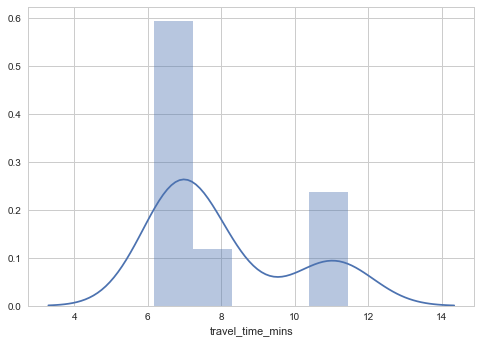

In [51]:
sns.distplot(get_trips_between_station_id(trip_data, 45, 97).loc[:, 'travel_time_mins']);

## Q2: How many trains travelled between two given stations?

37: Raffles Place


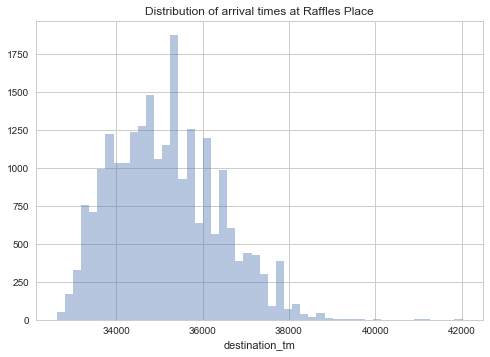

In [52]:
most_common_destination_station = trip_data['destination_id'].value_counts().idxmax()
print('{}: {}'.format(most_common_destination_station, mrt_stations[most_common_destination_station]))

fig, ax = plt.subplots()
sns.distplot(trip_data.loc[trip_data['destination_id'] == most_common_destination_station, 'destination_tm'], kde=False, ax=ax)
ax.set_title('Distribution of arrival times at {}'.format(mrt_stations[most_common_destination_station]));

## Q3: Number of people on an edge at a given time

In [53]:
start_station = get_idx(mrt_stations, 'Clementi')
end_station = get_idx(mrt_stations, 'Kallang')

travel_path = nx.astar_path(train_network, start_station, end_station)
list(map(lambda x: (x, mrt_stations.loc[x]), travel_path))

[(13, 'Clementi'),
 (45, 'Dover'),
 (97, 'Commonwealth'),
 (35, 'Queenstown'),
 (76, 'Redhill'),
 (19, 'Tiong Bahru'),
 (40, 'Outram Park'),
 (9, 'Tanjong Pagar'),
 (37, 'Raffles Place'),
 (42, 'City Hall'),
 (0, 'Bugis'),
 (34, 'Lavender'),
 (36, 'Kallang')]

In [54]:
t0 = convert_time_to_int('9:25:00')

time_along_travel_path = {travel_path[0]: t0}
for v1, v2 in zip(travel_path, travel_path[1:]):
    time_along_travel_path[v2] = time_along_travel_path[v1] + int(train_network[v1][v2]['weight'] * 60)

for s_id, t in sorted(time_along_travel_path.items(), key=lambda x: x[1]):
    print('{0}: {1}'.format(mrt_stations[s_id], t))

Clementi: 33900
Dover: 34268
Commonwealth: 34694
Queenstown: 34977
Redhill: 35312
Tiong Bahru: 35622
Outram Park: 36019
Tanjong Pagar: 36306
Raffles Place: 36620
City Hall: 36934
Bugis: 37250
Lavender: 37563
Kallang: 37868


In [55]:
from difflib import SequenceMatcher

def longest_common_sequence(a, b):
    s = SequenceMatcher(None, a, b)
    return s.find_longest_match(0, len(a), 0, len(b))

In [56]:
def graph_path_length(g, path, weight_label='weight'):
    if len(path) < 2:
        return 0
    plen = 0
    for v1, v2 in zip(path, path[1:]):
        plen += g[v1][v2][weight_label]
    return plen

In [57]:
trip_idxs_along_travel_path = {}

for (o_id, d_id), df in trip_data.groupby(['origin_id', 'destination_id'], sort=False):
    path = nx.astar_path(train_network, o_id, d_id)
    _, path_common_idx, common_path_len = longest_common_sequence(travel_path, path)
    if common_path_len == 0:
        continue

    min_start_time = t0 - int(graph_path_length(train_network, path[0:(path_common_idx+1)]) * 60)
    max_start_time = min_start_time + (TRAVEL_TIME_TOLERANGE_RANGE * 60)
    shared_trips = df[(min_start_time <= df['origin_tm']) & (df['origin_tm'] <= max_start_time)]

    common_segment = path[path_common_idx:(path_common_idx + common_path_len)]
    for edge in zip(common_segment, common_segment[1:]):
        if edge in trip_idxs_along_travel_path:
            trip_idxs_along_travel_path[edge] = trip_idxs_along_travel_path[edge].union(shared_trips.index)
        else:
            trip_idxs_along_travel_path[edge] = shared_trips.index.copy()

In [58]:
for v1, v2 in zip(travel_path, travel_path[1:]):
    print('{} to {}: {} pax'.format(mrt_stations[v1], mrt_stations[v2], trip_idxs_along_travel_path[(v1, v2)].size))

Clementi to Dover: 759 pax
Dover to Commonwealth: 765 pax
Commonwealth to Queenstown: 558 pax
Queenstown to Redhill: 609 pax
Redhill to Tiong Bahru: 633 pax
Tiong Bahru to Outram Park: 705 pax
Outram Park to Tanjong Pagar: 648 pax
Tanjong Pagar to Raffles Place: 573 pax
Raffles Place to City Hall: 426 pax
City Hall to Bugis: 303 pax
Bugis to Lavender: 291 pax
Lavender to Kallang: 291 pax
